In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

SAMPLE_NUMBER = 213

from sklearn.linear_model import LinearRegression # linear regression
from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import mean_squared_error # calculate error

from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import max_error, mean_absolute_error # calculate error

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression # linear regression

In [231]:
def read_filename(filename):

	# read table
	df = pd.read_csv(filename, sep='\t', decimal='.', header=None)

	# EG, FILENAME='PL_PC_records/PL and PC record-535-b-2.txt' --> ID_STRING='535-b-2.txt'
	id_string = filename.split('/')[2]
	cc = id_string.split('_') # split into parts with - inbetween

	print (cc)

	wavelength = cc[0] # wavelength
	location = cc[3] # background (b) or nv-center (nv)
	voltage = cc[2]

	# file has rows for columns, thus transpose
	df = df.transpose()

	# assign column meaning
	df['Laser Power (V)'] = df[0] # the header became the index after transposition
	df['PL (counts/s)'] = df[1]
	df['PC (pA)'] = df[2]

	# make the index a simple counter
	df = df.reset_index()

	# keep columns of interest
	df = df[['Laser Power (V)', 'PL (counts/s)', 'PC (pA)']]

	# assign identifiers to dataframe
	df['Wavelength'] = int(wavelength)
	df['Location'] = location
	df['Voltage'] = voltage

	df['Laser Power (V)'] = df['Laser Power (V)'].astype(float)
	df['PL (counts/s)'] = df['PL (counts/s)'].astype(float)
	df['PC (pA)'] =  df['PC (pA)'].astype(float)

	return df, wavelength, location, voltage

def read_experiment(fg, bg, plot=True):
	nv_df_0V, _ , _ , _ = read_filename(fg)
	nv_df_0V_BG, _ , _ , _ = read_filename(bg)

	# showcase Laser Power x PL
	if plot:
		fig, (ax1,ax2) = plt.subplots(1,2, figsize=(7,2.5))  # 1 row, 2 columns
		nv_df_0V.plot.scatter(x='Laser Power (V)', y='PL (counts/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")
		nv_df_0V_BG.plot.scatter(x='Laser Power (V)', y='PL (counts/s)', ax=ax2, title=f"Background {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")

	# plt.plot(X_test, y_pred,color='k')

	return nv_df_0V, nv_df_0V_BG

def read_experiment_w_exp_volt(wavelength, experiment_n, volt, background_picks, plot=False):
	
	background_n = background_picks[wavelength][volt]

	filename_fg = f'./SAT_CURVE/{wavelength}_NV_{volt}_fg_{experiment_n}.txt'
	filename_bg = f'./SAT_CURVE/{wavelength}_NV_{volt}_bg_{background_n}.txt'

	df_fg, df_bg = read_experiment(filename_fg, filename_bg, plot)

	df = fit_background(df_fg, df_bg, plot)

	df['wavelength'] = wavelength
	df['experiment #'] = experiment_n
	df['sample'] = SAMPLE_NUMBER

	return df #, df_fg, df_bg

def fit_background(df_nv_fg, df_nv_bg, plot=True):

	# select first and last few items from background to make a better fit
	df_nv_bg = pd.concat([df_nv_bg.head(5), df_nv_bg.tail(5)]).reset_index(drop=True)
	
	# fit background PL(V) function, should be linear
	X = df_nv_bg['Laser Power (V)'].to_numpy()
	y = df_nv_bg['PL (counts/s)'].to_numpy()

	# reshape data - [a,b,c,d] -> [[a], [b], [c], [d]] (because we have 1 feature for X)
	X = X.reshape(-1, 1)

	# fit regression
	reg = LinearRegression().fit(X, y)

	# predict on unseen values (X_test)
	y_pred = reg.predict(X)

	# plot input values, and fit
	if plot:
		fig, (ax1) = plt.subplots(1,1, figsize=(5,2.5))  # 1 row, 2 columns
		plt.scatter(X, y,color='r') 
		plt.plot(X, y_pred,color='k')

	# conver the column into a readily base for regressing
	laser_power_nv = df_nv_fg['Laser Power (V)'].to_numpy().reshape(-1,1)

	# apply PL-count Regression
	df_nv_fg['PL_background'] = reg.predict(laser_power_nv)

	# subtract background counts from NV counts
	df_nv_fg['PL_actual (#/s)'] = df_nv_fg['PL (counts/s)'] - df_nv_fg['PL_background']

	if plot:
		fig, (ax1) = plt.subplots(1,1, figsize=(5,2.5))  # 1 row, 2 columns
		df_nv_fg.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power vs PhotoLuminesence")

	return df_nv_fg

def map_to_mw(wavelength, df):

	# pick out wavelength
	fit = wavelength_dict[wavelength]

	# apply converion to df
	df['Laser Power (mW)'] = fit.predict(df['Laser Power (V)'].to_numpy().reshape(-1,1))

	return df

def perform_fit(curve_fit, df):
	# df_0V = nv_df_0V
	fit_0, _ = get_fit_params(func_to_fit, df)
	fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
	df.plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)', c='green', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

	x_1 = df['Laser Power (mW)'].to_numpy()

	plt.plot(x_1, curve_fit(x_1, *fit_0), 'g--', c='green', label='NV 0V - fit: b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(fit_0))

	ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Natural Log PL -  Voltage Sweep at varying laser powers - 535nm")
	ax1.set_xlabel("Laser Power (mW)")
	ax1.set_ylabel("Photoluminescence (#/s)")
	ax1.legend()
	ax1.grid(True)

	plt.legend()

def perform_fit_ax(curve_fit, ax1, df, color='green', scatter=True, legend=False):
	# df_0V = nv_df_0V
	fit_0, _ = get_fit_params(curve_fit, df)

	if scatter:
		df.plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)', c=color, ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

	x_1 = df['Laser Power (mW)'].to_numpy()
	x_1.sort()

	plt.plot(x_1, curve_fit(x_1, *fit_0), 'g--', c=color, label='NV 0V - fit: e=%5.3f, ke/kr=%5.3f, k8/km=%5.3f, kd/km=%5.3f' % tuple(fit_0))

	ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Natural Log PL -  Voltage Sweep at varying laser powers - 535nm")
	ax1.set_xlabel("Laser Power (mW)")
	ax1.set_ylabel("Photoluminescence (#/s)")

	if legend:
		ax1.legend()
	ax1.grid(True)

	if legend:
		plt.legend()

	return fit_0[2]

def get_fit_params(func_to_fit, df):
	# data
	x = df['Laser Power (mW)'].to_numpy()
	y = df['PL_actual (#/s)'].to_numpy()

	# function fit
	popt, pcov = curve_fit(func_to_fit, x, y,
		p0=[100000, 10, 10, 10],
		bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)),
		maxfev=100000
	)
	
	return popt, pcov

## Laser Power - V to mW Conversion

In [236]:
# 535 - laser power fitting
x = np.array([0.10334, 3.20574]).reshape(-1, 1)
y = [1.51800, 60.6]
laser_power_v_to_mW_535 = LinearRegression().fit(x, y)

# 540 - laser power fittingx
x = np.array([0.413991, 8.34689]).reshape(-1, 1)
y = [2.86, 61.1]
laser_power_v_to_mW_540 = LinearRegression().fit(x, y)

# 545 - laser power fittingx
x = np.array([0.394525, 5.7888]).reshape(-1, 1)
y = [3.82, 60.2]
laser_power_v_to_mW_545 = LinearRegression().fit(x, y)

# 550 - laser power fittingx
x = np.array([0.361688, 9.14476]).reshape(-1, 1)
y = [2.16, 58.9]
laser_power_v_to_mW_550 = LinearRegression().fit(x, y)

# 555 - laser power fittingx
x = np.array([0.13036, 3.31927]).reshape(-1, 1)
y = [1.408, 53.7]
laser_power_v_to_mW_555 = LinearRegression().fit(x, y)

wavelength_dict = {
	535: laser_power_v_to_mW_535,
	540: laser_power_v_to_mW_540,
	545: laser_power_v_to_mW_545,
	550: laser_power_v_to_mW_550,
	555: laser_power_v_to_mW_555
}

In [239]:
wavelength_dict[555].predict([[4.5]])

array([73.06170452])

## Read Raw Data

In [107]:
background_picks = {
	'535': {
		'0V':'2',
	},
	'540': {
		'0V':'2',
		'm10V':'1',
		'10V':'1',
	},
	'545': {
		'0V':'1',
	},
	'550': {
		'0V':'2',
	}
}

['550', 'NV', '0V', 'fg', '1.txt']
['550', 'NV', '0V', 'bg', '2.txt']


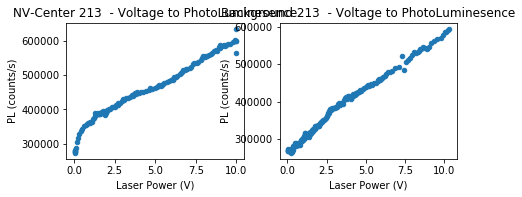

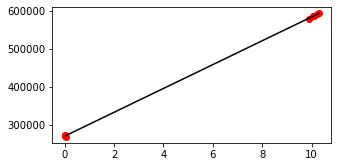

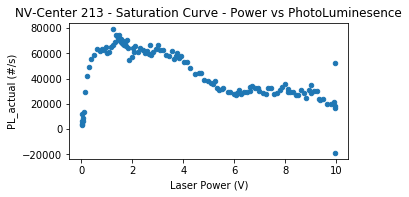

In [108]:
df = read_experiment_w_exp_volt('550', '1', '0V', background_picks, True)

In [109]:
directory = 'SAT_CURVE'

dfs_wavelength = {}

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):

        # skip if this isn't out file
        filename = f.split('/')[1]
        params = filename.split('_')

        if (len(params)<5):
            continue

        wavelength = params[0]
        voltage = params[2]
        exp = params[4].split('.')[0]

        print (wavelength, voltage, exp)

        df = read_experiment_w_exp_volt(wavelength, exp, voltage, background_picks)
        df = map_to_mw(int(wavelength), df)

        if wavelength not in dfs_wavelength:
            dfs_wavelength[wavelength] = {}

            if voltage not in dfs_wavelength[wavelength]:
                dfs_wavelength[wavelength][voltage] = []
                dfs_wavelength[wavelength][voltage].append(df)
            else:
                dfs_wavelength[wavelength][voltage].append(df)

        else:

            if voltage not in dfs_wavelength[wavelength]:
                dfs_wavelength[wavelength][voltage] = []
                dfs_wavelength[wavelength][voltage].append(df)
            else:
                dfs_wavelength[wavelength][voltage].append(df)

540 m10V 1
['540', 'NV', 'm10V', 'fg', '1.txt']
['540', 'NV', 'm10V', 'bg', '1.txt']
540 0V 8
['540', 'NV', '0V', 'fg', '8.txt']
['540', 'NV', '0V', 'bg', '2.txt']
540 m10V 6
['540', 'NV', 'm10V', 'fg', '6.txt']
['540', 'NV', 'm10V', 'bg', '1.txt']
540 m10V 4
['540', 'NV', 'm10V', 'fg', '4.txt']
['540', 'NV', 'm10V', 'bg', '1.txt']
540 m10V 5
['540', 'NV', 'm10V', 'fg', '5.txt']
['540', 'NV', 'm10V', 'bg', '1.txt']
540 m10V 1
['540', 'NV', 'm10V', 'fg', '1.txt']
['540', 'NV', 'm10V', 'bg', '1.txt']
540 m10V 2
['540', 'NV', 'm10V', 'fg', '2.txt']
['540', 'NV', 'm10V', 'bg', '1.txt']
540 m10V 3
['540', 'NV', 'm10V', 'fg', '3.txt']
['540', 'NV', 'm10V', 'bg', '1.txt']
535 0V 4
['535', 'NV', '0V', 'fg', '4.txt']
['535', 'NV', '0V', 'bg', '2.txt']
540 0V 1
['540', 'NV', '0V', 'fg', '1.txt']
['540', 'NV', '0V', 'bg', '2.txt']
545 0V 1
['545', 'NV', '0V', 'fg', '1.txt']
['545', 'NV', '0V', 'bg', '1.txt']
550 0V 1
['550', 'NV', '0V', 'fg', '1.txt']
['550', 'NV', '0V', 'bg', '2.txt']
540 10V 1


Clean data

In [136]:
for w, voltages in dfs_wavelength.items(): # wavelength
	for v, experiments in voltages.items(): # voltage
		for ii, df in enumerate(experiments): # experiment
			
			dfs_wavelength[w][v][ii] = df.loc[df['PL (counts/s)'] > 0,:]

			dfs_wavelength[w][v][ii] = df.loc[df['PL_actual (#/s)'] > 0,:]

Gather ensemble data across voltages for 540nm

In [92]:
nv_540_0v = dfs_wavelength['540']['0V'][0].append(dfs_wavelength['540']['0V'][1:])
nv_540_m10v = dfs_wavelength['540']['m10V'][0].append(dfs_wavelength['540']['m10V'][1:])
nv_540_10v = dfs_wavelength['540']['10V'][0].append(dfs_wavelength['540']['10V'][1:])

## toMw & Fitting 

In [189]:
1 / 0.02

50.0

In [226]:
def func_to_fit(x, b, c, d, e):
    return ((x**2) + b*x) / (c*(x**2) + d*x + e)

# km = (1 / 186.12E-9) 
# kn = (1 / 14.98E-9)

km = (1 / 186.12E-9)
kn = (1 / 14.98E-9)
kr = (1 / 14E-9)

# km = 5.3728E-6
# kn = 66.756E-6
# kr = 13E-9

def daria_fit(x, e, a, b, c):
	d = km/kn  #? <-- Wrong Fixed RATIO (but works)
	# d = kn/km  # <-- Correct RATIO
	
	# b = 0
	
	return (e) / (1 + (1/(a*x)) + ((c*x)/(1+b*x)) + ((d)/(1+b*x) ) )

### Ensemble Fit

1.1122909805718883e-17

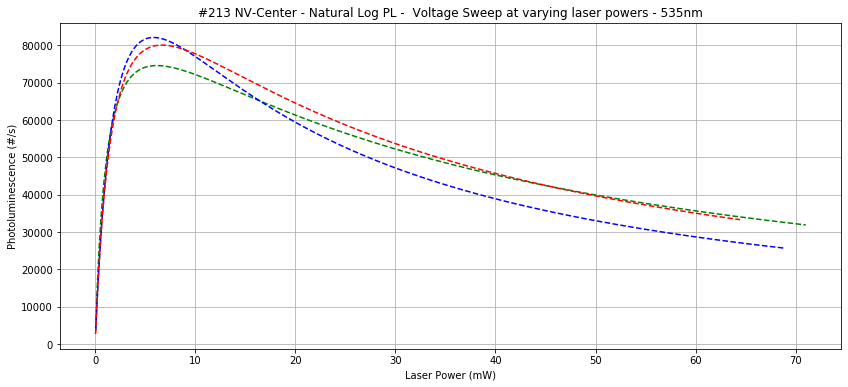

In [227]:
nv_540_0v = map_to_mw(540, nv_540_0v)
nv_540_m10v = map_to_mw(540, nv_540_m10v)
nv_540_10v = map_to_mw(540, nv_540_10v)

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
perform_fit_ax(daria_fit, ax1, nv_540_0v, 'green', scatter=False)
perform_fit_ax(daria_fit, ax1, nv_540_m10v, 'blue', scatter=False)
perform_fit_ax(daria_fit, ax1, nv_540_10v, 'red', scatter=False)

2909.1962879834173

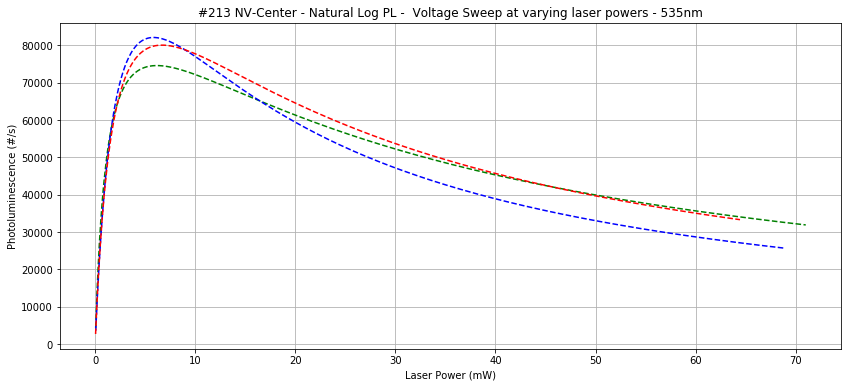

In [222]:
nv_540_0v = map_to_mw(540, nv_540_0v)
nv_540_m10v = map_to_mw(540, nv_540_m10v)
nv_540_10v = map_to_mw(540, nv_540_10v)

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
perform_fit_ax(func_to_fit, ax1, nv_540_0v, 'green', scatter=False)
perform_fit_ax(func_to_fit, ax1, nv_540_m10v, 'blue', scatter=False)
perform_fit_ax(func_to_fit, ax1, nv_540_10v, 'red', scatter=False)

### Saturation Curves - Varying Voltage

In [233]:
nv_550_0v = dfs_wavelength['550']['0V'][0].append(dfs_wavelength['550']['0V'][1:])

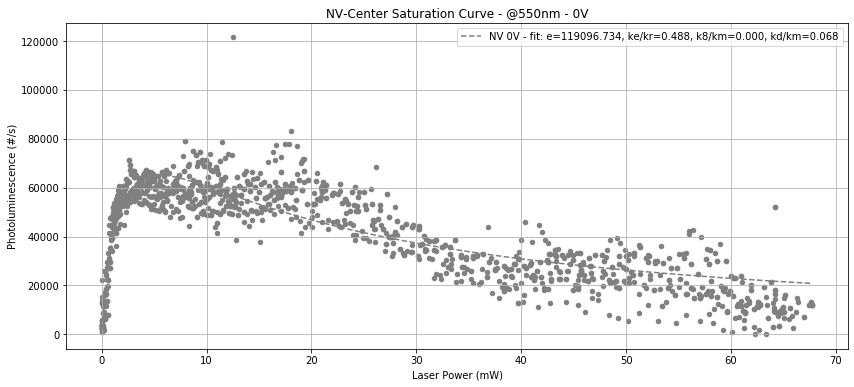

In [234]:
df_k8 = pd.DataFrame(columns=['wavelength', 'k8'])

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
k8_over_km = perform_fit_ax(daria_fit, ax1, nv_550_0v, 'grey', legend=True)

df_k8 = df_k8.append({'wavelength': w, 'k8': k8_over_km*km}, ignore_index=True)

ax1.set_title(f"NV-Center Saturation Curve - @{w}nm - {v}")
ax1.set_xlabel("Laser Power (mW)")
ax1.set_ylabel("Photoluminescence (#/s)")

df_k8.wavelength = df_k8.wavelength.astype(float)

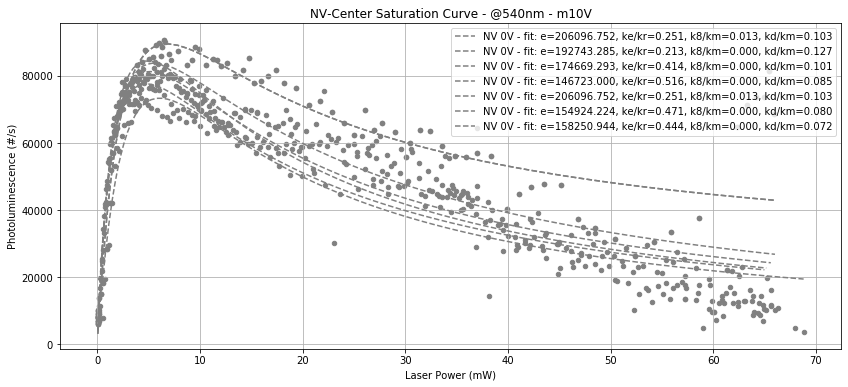

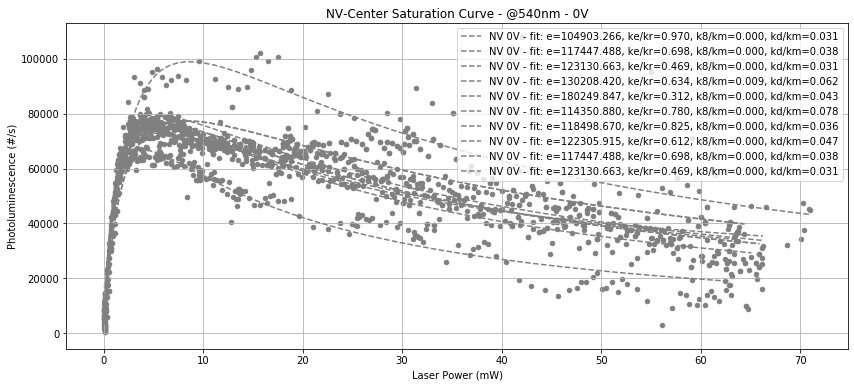

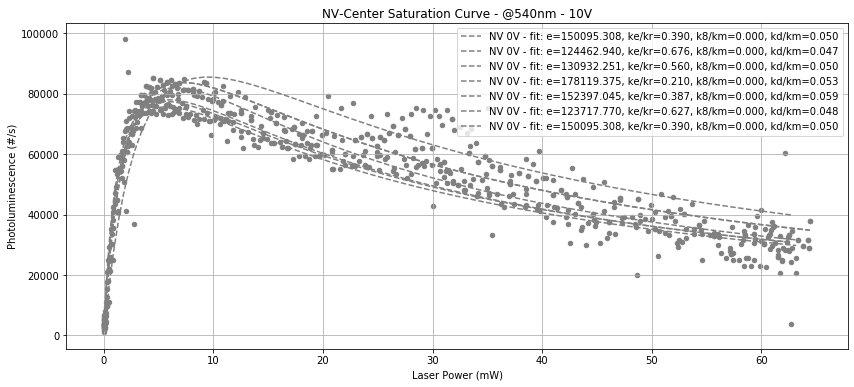

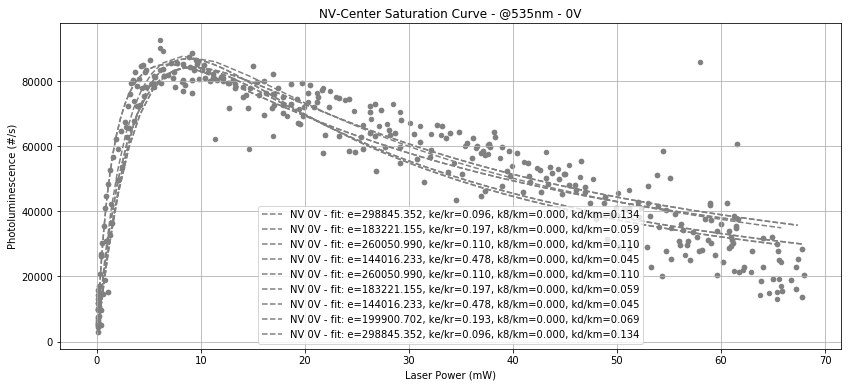

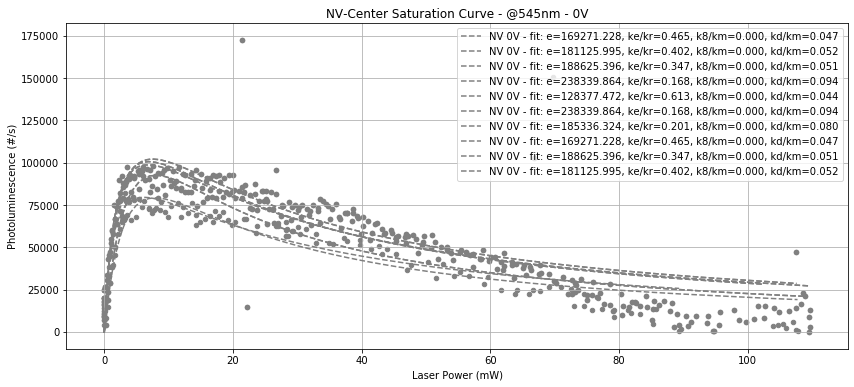

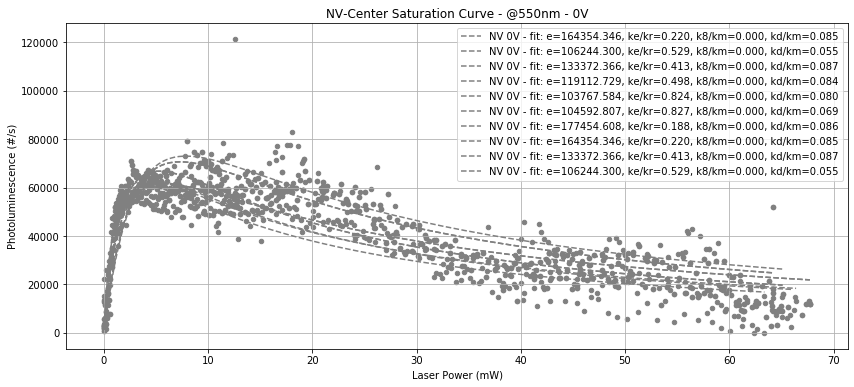

In [232]:
df_k8 = pd.DataFrame(columns=['wavelength', 'k8'])

for w, voltages in dfs_wavelength.items(): # wavelength
	for v, experiments in voltages.items(): # voltage

		fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns

		for ii, df in enumerate(experiments): # experiment
			k8_over_km = perform_fit_ax(daria_fit, ax1, df, 'grey', legend=True)
			
			df_k8 = df_k8.append({'wavelength': w, 'k8': k8_over_km*km}, ignore_index=True)

			ax1.set_title(f"NV-Center Saturation Curve - @{w}nm - {v}")
			ax1.set_xlabel("Laser Power (mW)")
			ax1.set_ylabel("Photoluminescence (#/s)")

df_k8.wavelength = df_k8.wavelength.astype(float)

Plotting k8

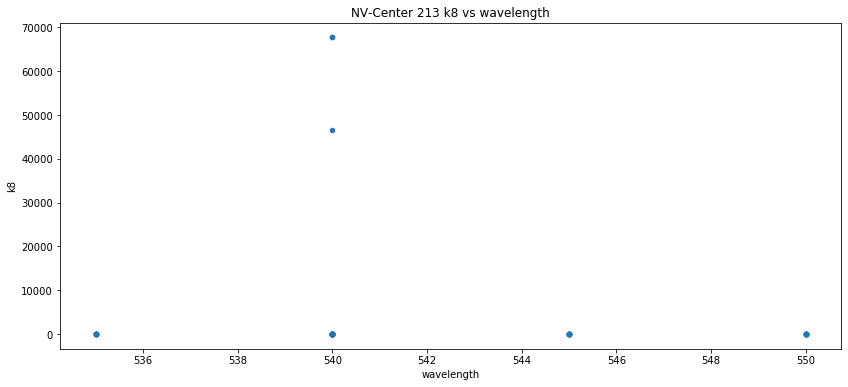

In [219]:
fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
df_k8.plot.scatter(x='wavelength', y='k8', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} k8 vs wavelength")